# JobSniffer: Fraudulent Job Posting Detection System

This Jupyter Notebook contains the definition and example usage of the `JobSniffer` class, which is designed to detect fraudulent behavior in job postings. It combines various machine learning techniques to assess the authenticity of job postings, including text-based feature analysis (TF-IDF, N-grams, lexical diversity), anomaly detection, and supervised classification.

## 1. Import Necessary Libraries

In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from nltk import ngrams, FreqDist
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

/opt/anaconda3/envs/TextMinning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Loading and Preprocessing

In [2]:
# Load and prepare data
df_1 = pd.read_csv('fake_job_postings.csv')
df_1.drop(['department', 'function', 'has_company_logo', 'has_questions', 'job_id', 'required_education', 'required_experience', 'telecommuting'], axis=1, inplace=True)

df_2 = pd.read_csv('Fake Postings.csv')
df = pd.concat([df_1, df_2], ignore_index=True, sort=False)

clean_df = df.dropna(subset=['description'])

fill_col = ['salary_range', 'company_profile', 'requirements', 'benefits', 'employment_type', 'industry', 'location']
clean_df[fill_col] = clean_df[fill_col].fillna('')

def preprocess(text: str) -> str: 
    """Basic cleaning: lowercase, remove non-alphanumeric, collapse spaces."""
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'#(?:phone|url)_\w+#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Preprocess and Normalize data
for col in ['company_profile', 'description', 'requirements', 'benefits']:
    clean_df[col] = clean_df[col].apply(preprocess)
    
clean_df.to_csv('fake_job_posting_clean.csv')

filtered_fakejob = clean_df[ clean_df['fraudulent'] == 1 ]
filtered_realjob = clean_df[ clean_df['fraudulent'] == 0 ]

/var/folders/r4/zwnf834j3fjd_sy76pvmzgbw0000gn/T/ipykernel_87326/3637274855.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[fill_col] = clean_df[fill_col].fillna('')
/var/folders/r4/zwnf834j3fjd_sy76pvmzgbw0000gn/T/ipykernel_87326/3637274855.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[col] = clean_df[col].apply(preprocess)


## 3. `JobSniffer` Class Definition

In [3]:
class JobSniffer:
    def __init__(self,
                 tfidf_params=None,
                 embedding_model_name='all-MiniLM-L6-v2',
                 anomaly_params=None,
                 rf_params=None):
        """
        Initialize JobSnifferAgent with optional hyperparameters.
        """
        # TF-IDF vectorizer
        self.tfidf = TfidfVectorizer(**(tfidf_params or {
            'min_df': 0.01,
            'max_df': 0.9,
            'ngram_range': (1, 2)
        }))
        
        # Sentence-BERT embedder
        self.embedder = SentenceTransformer(embedding_model_name)

        # Anomaly detector
        self.anomaly_detector = IsolationForest(**(anomaly_params or {
            'n_estimators': 100,
            'contamination': 0.02,
            'random_state': 6410
        }))
        
        # Supervised classifier
        self.classifier = RandomForestClassifier(**(rf_params or {
            'n_estimators': 200,
            'max_depth': 10,
            'random_state': 6410
        }))
        
        # Red-flag n-grams placeholder
        self.red_flag_ngrams = []
        
        # Sentiment analyzer
        #self.sentiment_analyzer = SentimentIntensityAnalyzer()

        # Summarization pipeline
        #self.summarizer = pipeline('summarization', model='facebook/bart-large-cnn')

        
    def _combine_text_cols(self, df: pd.DataFrame, cols: list) -> list:
        """Concatenate multiple text columns into single documents."""
        return df[cols].fillna('').astype(str).agg(' '.join, axis=1).tolist()

    def update_red_flags(self,
                         fake_df: pd.DataFrame,
                         cols: list,
                         n: int = 2,
                         top_k: int = 10):
        """Compute top_k n-grams from fake_df over specified cols."""
        all_grams = []
        for col in cols:
            tokens_list = fake_df[col].dropna().astype(str).str.split().tolist()
            for tokens in tokens_list:
                all_grams.extend(ngrams(tokens, n))
        freq_dist = FreqDist(all_grams)
        self.red_flag_ngrams = [" ".join(gram) for gram, _ in freq_dist.most_common(top_k)]
        
    def extract_entities(self, texts: list) -> pd.DataFrame:
        """
        Run NER on a list of texts and return counts per entity label.
        """
        records = []
        # Use spaCy's pipeline to batch-process texts
        for doc in self.nlp.pipe(texts, batch_size=20):
            counts = {}
            # Initialize counts for each entity type encountered
            for ent in doc.ents:
                counts.setdefault(ent.label_, 0)
                counts[ent.label_] += 1
            records.append(counts)
        # Convert list of dicts to DataFrame, filling missing with zeros
        return pd.DataFrame(records).fillna(0)

    def analyze_sentiment(self, texts: list) -> pd.DataFrame:
        """
        Compute VADER sentiment scores for each text.
        """
        recs = []
        for t in texts:
            # polarity_scores returns dict with pos/neu/neg/compound
            recs.append(self.sentiment_analyzer.polarity_scores(t))
        return pd.DataFrame(recs)

    def summarize(self, text: str) -> str:
        """
        Generate a concise summary of a single text using BART.
        """
        # Summarizer returns a list; take the summary_text field
        summ = self.summarizer(text, max_length=60, min_length=20, do_sample=False)
        return summ[0]['summary_text']

    def extract_features(self, df: pd.DataFrame, cols: list) -> np.ndarray:
        """
        Assemble the full feature matrix for modeling:
         - TF-IDF vectors
         - (Optional) Transformer embeddings
         - Rule-based red-flag indicators
         - Lexical diversity metric
         - NER counts
         - Sentiment scores
         - Emotion scores
        """
        # Combine and preprocess texts
        texts = self._combine_text_cols(df, cols)

        # TF-IDF
        X_tfidf = self.tfidf.transform(texts).toarray()

        # Embeddings
        X_emb = self.embedder.encode(texts, show_progress_bar=False)

        # Red-flag flags
        """ For each document, check if it contains each red flag phrase in the self.red_flag_ngrams list.
            If so, the feature value is 1, otherwise 0. This creates a binary feature for each red flag phrase."""
        X_flags = np.array([
            [int(ng in doc) for ng in self.red_flag_ngrams]
            for doc in texts
        ])

        # Lexical diversity
        """ Calculate the lexical diversity of each document: number of unique words / total number of words
            This ratio can measure the richness of the text. For example, scam text may have high lexical repetition and low lexical diversity."""
        X_lexdiv = np.array([
            [len(set(doc.split())) / len(doc.split())] if doc.split() else [0]
            for doc in texts
        ])

        # Sentiment polarity scores
        #sent_df = self.analyze_sentiment(texts)
        
        # Concatenate horizontally all feature blocks
        return np.hstack([
            X_tfidf, X_emb, X_flags, X_lexdiv#, #ner_df.values, 
            #sent_df.values#, emo_df.values
        ])

    def fit(self,
            df: pd.DataFrame,
            text_cols: list,
            label_col: str):
        """
        Train the pipelines:
         1) Fit TF-IDF on entire corpus
         2) Fit anomaly detector on genuine postings only
         3) Fit supervised classifier on all labeled data
        """
        # Fit TF-IDF
        corpus = self._combine_text_cols(df, text_cols)
        self.tfidf.fit(corpus)

        # Anomaly on genuine only
        real_df = df[df[label_col] == 0]
        X_real = self.extract_features(real_df, text_cols) # Extract features of these real job postings
        self.anomaly_detector.fit(X_real)

        # Supervised classifier
        X_all = self.extract_features(df, text_cols)
        y_all = df[label_col].astype(int).values # Get the corresponding label (0 for non-scam, 1 for scam).
        self.classifier.fit(X_all, y_all)

    def predict_proba(self,
                      row: pd.Series,
                      text_cols: list) -> dict:
        """
        Score a single job posting with the ensemble:
         - rule_score: fraction of red-flag phrases triggered
         - anomaly_score: outlier score from IsolationForest
         - classifier_prob: probability of fraud from RandomForest
         - final_score: weighted combination of the three
        """
        temp_df = pd.DataFrame([row])
        X_feat = self.extract_features(temp_df, text_cols) # Extract features of current job postings

        # Rule score
        """ This is a score based on "red flag N-grams". flag_block contains a binary flag for the presence or absence of each red flag N-gram in the document.
            flag_block.mean(): Calculates the average proportion of red flag N-grams in a document (i.e., how many red flag N-grams appear in this document). 
            The higher this score, the more red flag phrases a document contains.
        """
        flag_block = X_feat[0, -len(self.red_flag_ngrams) - 1 : -1] if self.red_flag_ngrams else np.array([0])
        rule_score = flag_block.mean()

        # Anomaly score
        """ The decision_function of IsolationForest returns a negative value, where smaller values indicate more anomalies.
            To make the score more intuitive (higher means more anomalies), it is negative.
            This score measures how much the job posting deviates from the "normal" pattern. The higher the score, the more likely it is to be an anomaly.
        """
        anomaly_score = -self.anomaly_detector.decision_function(X_feat)[0]

        # Classifier
        clf_prob = self.classifier.predict_proba(X_feat)[0, 1] # The higher this probability, the more likely the classifier thinks it is a scam.

        # Ensemble
        final_score = 0.3 * rule_score + 0.3 * anomaly_score + 0.4 * clf_prob # Ensemble three different scores and assign different weights

        return {
            'rule_score': rule_score,
            'anomaly_score': anomaly_score,
            'classifier_prob': clf_prob,
            'final_score': final_score
        }

## 4. Model Training

In [6]:
n = min(len(filtered_realjob), len(filtered_fakejob))
df0_bal = filtered_realjob.sample(n=n, random_state=6410)
df1_bal = filtered_fakejob.sample(n=n, random_state=6410)

# Merge into a balanced DataFrame
df_balanced = pd.concat([df0_bal, df1_bal]).sample(frac=1, random_state=6410).reset_index(drop=True)

# Do the 70/30 split
df_train, df_test = train_test_split(
    df_balanced,
    test_size=0.3,
    random_state=6410,
    stratify=df_balanced['fraudulent']  # At this time, the proportion of each category is 50%
)

df_train.to_csv('JobSnifferTrainDataset.csv')
df_test.to_csv('JobSnifferTestDataset.csv')

# Initialize agent
agent = JobSniffer()

# Dynamically set red-flag n-grams
agent.update_red_flags(
    fake_df=filtered_fakejob,
    cols=['company_profile','description','requirements','benefits'],
    n=2,
    top_k=10
)


# Train models
agent.fit(
    df=df_train,
    text_cols=['company_profile','description','requirements','benefits'],
    label_col='fraudulent'
)

## 5. Model Validating

ROC-AUC:  0.996
Precision: 1.000
Recall:    0.927
F1-score:  0.962


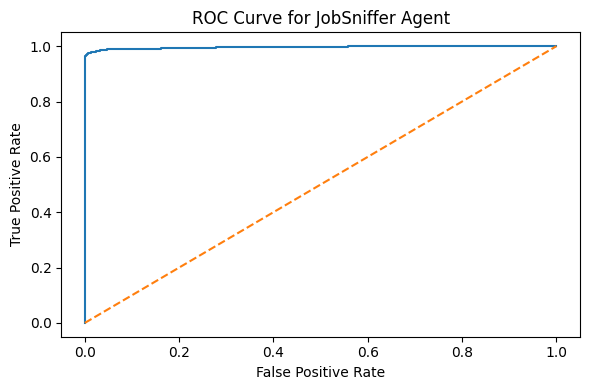

                 Predicted Real (0)  Predicted Fake (1)
Actual Real (0)                3260                   0
Actual Fake (1)                 239                3020


In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Define text columns and label column
text_cols = ['company_profile', 'description', 'requirements', 'benefits']
label_col = 'fraudulent'

# Apply agent.predict_proba to each test row to get final_score
probs = df_test.apply(
    lambda row: agent.predict_proba(row, text_cols)['final_score'],
    axis=1
).values

# True labels
y_true = df_test[label_col].astype(int).values

# Binarize predictions with a threshold
threshold = 0.5
y_pred = (probs >= threshold).astype(int)

# Compute metrics
roc_auc = roc_auc_score(y_true, probs)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Print metrics
print(f"ROC-AUC:  {roc_auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for JobSniffer Agent")
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Real (0)', 'Fake (1)']
# Create DataFrame with labeled rows and columns
cm_df = pd.DataFrame(cm, index=[f"Actual {name}" for name in class_names],
                        columns=[f"Predicted {name}" for name in class_names])

# Display the labeled confusion matrix
print(cm_df)